# Replicating ADH 2013

**Spencer Lyon** 

**August 2017**

In this notebook I use the tools in the PyData ecosystem to replicate the main regressions and figures from  Autor, D. H., Dorn, D., & Hanson, G. H. (2013). The China Syndrome: Local Labor Market Effects of Import Competition in the United States. American Economic Review, 103(6), 2121–2168. http://doi.org/10.1257/aer.103.6.2121 (ADH)

Here I take as given the main data file provided by ADH: `workfile_china.dta`.

The code in this notebook mirrors the code from `czone_analysis_ipw_final.do`, the Stata do file provided by the authors.

## Setup

To begin I load the Python packages I will be using. If you would like to run these commands yourself, you will need to have these packages installed on your system. I recommend following the [instructions provided by QuantEcon](https://lectures.quantecon.org/py/getting_started.html) and using the Anaconda python distribution.

On top of a basic Anaconda installation you will additionally need to install the `linearmodels` package, which can be done by entering the following command at the terminal (OSX/Linux) or command prompt (Windows):

```bash
pip install linearmodels
```

In [1]:
# Load packages
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
import numpy as np

# only need these to print version numbers and date
import sys
import linearmodels
import statsmodels
from datetime import datetime


# print date and version numbers
print("Today's date is", datetime.today().strftime("%A, %B %d, %Y"))
print("Version numbers:")

_msg = "\t{package:15s}: {number}"
print(_msg.format(package="pandas", number=pd.__version__))
print(_msg.format(package="numpy", number=np.__version__))
print(_msg.format(package="statsmodels", number=statsmodels.__version__))
print(_msg.format(package="linearmodels", number=linearmodels.__version__))
print(_msg.format(package="python", number=sys.version))

/Users/sglyon/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Today's date is Monday, August 28, 2017
Version numbers:
	pandas         : 0.20.1
	numpy          : 1.12.1
	statsmodels    : 0.8.0
	linearmodels   : 3.5
	python         : 3.6.1 |Anaconda 4.4.0 (x86_64)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


### Helper functions

Throughout the computations ADH weight observations by the beginning of period commuting zone population.

Both `statsmodels` and `linearmodels` provide weighted versions of the regressions. However, for summary statistics, there is not a suitable implementation in `pandas` or `numpy`. So, below is a collection of functions that allow me to mimic the output of stata's `sum ... [aw=weights]` command in Python.

In [2]:
## Helper routines for weighted descriptive stats
def xbar(x, w):
    return np.dot(x, w) / np.sum(w)

def w_stdev(x, w):
    n = x.shape[0]
    W = np.sum(w)
    xb = xbar(x, w)
    return np.sqrt((n/(W * (n - 1))) * np.sum(w * (x - xb)**2))

def w_mean_std(x, w):
    return xbar(x, w), w_stdev(x, w)

def wquantile(vals_in, weights_in, probs_in):
    """
    Taken from StatsBase.jl
    """
    weights = np.asarray(weights_in)
    probs = np.asarray(probs_in)
    
    if isinstance(vals_in, pd.DataFrame):
        datas = [wquantile(vals_in[c], weights, probs) for c in vals_in.columns]
        return pd.concat(datas, axis=1)
        
    vals = np.asarray(vals_in)
    
    # full sort
    inds = np.argsort(vals)
    v = vals.copy()[inds]
    w = weights.copy()[inds]
    wsum = w.sum()

    # prepare percentiles
    p_inds = np.argsort(probs)
    p = np.clip(probs.copy()[p_inds], 1e-10, 1-1e-10)

    # prepare out vector
    N = v.size
    out = np.empty(p.size)
    out[:] = v[-1]

    # start looping on quantiles
    cumulative_weight, Sk, Skold =  0.0, 0.0, 0.0
    vk, vkold = 0.0, 0.0
    k = 0
    for i in range(p.size):
        h = p[i] * (N - 1) * wsum
        if h == 0:
            # happens when N or p or wsum equal zero
            out[p_inds[i]] = v[0]
        else:
            while Sk <= h:
                # happens in particular when k == 0
                vk = v[k]
                wk = w[k]
                cumulative_weight += wk
                if k >= N:
                    # out was initialized with maximum v
                    return out
                k += 1
                Skold, vkold = Sk, vk
                vk = v[k]
                wk = w[k]
                Sk = (k - 1) * wk + (N - 1) * cumulative_weight
            # in particular, Sk is different from Skold
            g = (h - Skold) / (Sk - Skold)
            out[p_inds[i]] = vkold + g * (vk - vkold)

    if isinstance(vals_in, pd.Series):
        res = pd.DataFrame(index=probs, data={vals_in.name: out})
    
    res.index.name = "quantile"
    return res

def wsummary(df, weights, qs=None):
    "looks like Stata's summarize variable [aw=weights], detail"
    if isinstance(df, pd.Series):
        return wsummary(df.to_frame(), weights, qs)
    
    if not isinstance(df, pd.DataFrame):
        msg = "wsummary only works with pandas Series or DataFrame"
        raise ValueError(msg)

    if qs is None:
        qs = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    
    if len(qs) > 0:
        quants = wquantile(df, weights, qs)
        quants.index.name = None
        new_index = ["{0:d}%".format(int(i*100)) for i in quants.index]
        quants.index = ["{0:d}%".format(int(i*100)) for i in quants.index]
        quantsT = quants.T
    else:
        quantsT = pd.DataFrame(index=df.columns)
    
    # add other descriptive stats
    quantsT["count"] = df.count()
    quantsT["mean"] = df.aggregate(lambda x: xbar(x, weights))
    quantsT["std"] = df.aggregate(lambda x: w_stdev(x, weights))
    quantsT["min"] = df.min()
    quantsT["max"] = df.max()
    out = quantsT.T
    
    if len(qs) > 0:
        row_order = ["count", "mean", "std", "min"] + new_index + ["max"]
        return out.loc[row_order]
    else:
        return out
    

### Load the data

The data is included in the file `workfile_china.dta`. This file was obtained from the [data page on David Dorn's website](http://www.ddorn.net/data.htm) and should be included in the same directory as this notebook.

We will read all the data in this file into a pandas `DataFrame`.

In [3]:
df = pd.read_stata("workfile_china.dta")

## The replication

Here I replicate the commands found in `czone_analysis_ipw_final.do`. The section headings match those of the comments in the stata file. I don't provide interpretation of their results, as those can be found in the original ADH paper and appendices.

### Descriptive statistics and regressions

#### Appendix Table 1: Imports per Worker

Growth in Chinese imports per worker, U.S. (in 1000 USD/worker)

In [4]:
# Dummy for 40 largest CZs (1990 pop)
pop1990 = df["l_popcount"] * (df["yr"] == 1990)
top40 = pop1990.sort_values(ascending=False).head(40).index

cols = ["city", "d_tradeusch_pw"]

# Largest and smalles exposure, top 40 cities, 1990s
df.loc[top40, cols].sort_values("d_tradeusch_pw", ascending=False)

,city,d_tradeusch_pw
1372,San Jose CA,3.150079
560,Providence RI,2.591957
500,Buffalo NY,2.241147
566,Boston MA,1.554798
1414,Portland OR,1.531284
1392,San Diego CA,1.516159
534,Newark NJ,1.316313
1398,Los Angeles CA,1.276940
574,Bridgeport CT,1.271309
964,Denver CO,1.227556


In [5]:
# Largest and smalles exposure, top 40 cities, 2000s
df.loc[
    (df["czone"].isin(df.loc[top40, "czone"])) & (df["yr"] == 2000),
    cols
].sort_values("d_tradeusch_pw", ascending=False)

,city,d_tradeusch_pw
1373,San Jose CA,7.323062
561,Providence RI,4.990930
1399,Los Angeles CA,3.587253
1393,San Diego CA,3.082844
1415,Portland OR,2.958373
457,Pittsburgh PA,2.950598
671,Chicago IL,2.931027
667,Milwaukee WI,2.929721
567,Boston MA,2.789791
1193,Dallas TX,2.772738


In [6]:
# Additional information: Relationship between China exposure and manufacturing share
for year in [1990, 2000]:
    df_year = df[df["yr"] == year]
    res = smf.wls(
        formula="d_tradeusch_pw ~ l_shind_manuf_cbp",
        data=df_year,
        weights=df_year["timepwt48"],

    ).fit(
        cov_type="cluster",
        cov_kwds={"groups": df_year["statefip"], 
                  # Default is true for both of these
                 }
    )
    
    print(f"Results for year {year}:\n\n")
    print(res.summary2())

Results for year 1990:


                 Results: Weigthed least squares
Model:              WLS              Adj. R-squared:     0.266    
Dependent Variable: d_tradeusch_pw   AIC:                2723.8259
Date:               2017-08-28 14:39 BIC:                2732.9900
No. Observations:   722              Log-Likelihood:     -1359.9  
Df Model:           1                F-statistic:        86.91    
Df Residuals:       720              Prob (F-statistic): 2.93e-12 
R-squared:          0.267            Scale:              0.0010013
------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
------------------------------------------------------------------
Intercept           -0.0715   0.0947 -0.7552 0.4501 -0.2571 0.1141
l_shind_manuf_cbp    0.0586   0.0063  9.3226 0.0000  0.0462 0.0709
------------------------------------------------------------------
Omnibus:             614.398      Durbin-Watson:       

#### Appendix Table 2: Descriptive Statistics

In [7]:
# Growth in Chinese imports per worker, U.S. (in 1000 USD/worker)
stats = df.groupby("yr").apply(lambda x: wsummary(x["d_tradeusch_pw"], x["timepwt48"]))
stats["d_tradeusch_pw"].unstack()

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
yr,,,,,,,,,,,,,,
1990,722.0,1.140272,0.992669,-0.075351,0.111435,0.209366,0.377810,0.623198,0.888580,1.315620,2.041117,2.694188,4.853174,25.405270
2000,722.0,2.627236,2.011937,-0.628958,0.317457,0.726976,1.027439,1.598546,2.113758,3.116083,4.292929,5.823032,10.344419,43.084604


In [8]:
# Create rebased per-worker level variables
l_no_workers_totcbp = df.groupby(
    ["czone", "yr"]
)["l_no_workers_totcbp"].sum()
df.set_index("czone", inplace=True)
df["l_no_workers_totcbp1990"] = l_no_workers_totcbp.xs(1990, level="yr")
df["l_no_workers_totcbp2000"] = l_no_workers_totcbp.xs(2000, level="yr")

for (v, suff) in [("usch", ""), ("otch", "_lag")]:
    # year-2000 imports relative to 1990 workforce
    df["x"] = (
        df[f"l_trade{v}_pw"] * 
        df["l_no_workers_totcbp"] /
        df["l_no_workers_totcbp1990"]
    ) * (df["yr"] == 2000)
    df[f"l_trade{v}_pw90_2000"] = df.groupby(df.index)["x"].sum()
    df.drop("x", axis=1, inplace=True)
    
    # year-2007 imports relative to 2000 workforce
    df[f"l_trade{v}_pw00_2007"] = df[f"l_trade{v}_pw"]+df[f"d_trade{v}_pw{suff}"]*0.7
    
    # year-2007 imports relative to 1990 workforce
    df[f"l_trade{v}_pw90_2007"] = (
        df[f"l_trade{v}_pw00_2007"]*
        df["l_no_workers_totcbp"]/
        df["l_no_workers_totcbp1990"]
    )*(df["yr"]==2000)
    
    # year-1991 imports relative to 2000 workforce
    df[f"l_trade{v}_pw00_1991"] = (
        df[f"l_trade{v}_pw"]*
        df["l_no_workers_totcbp1990"]/
        df["l_no_workers_totcbp2000"]
    )*(df["yr"]==1990)
    
df.reset_index(inplace=True)

In [9]:
# Summary stats: 1991/2000/2007 imports relative to 1990 workforce
df1990 = df.loc[df.yr == 1990]
df2000 = df.loc[df.yr == 2000]
stats90 = wsummary(df1990["l_tradeusch_pw"], df1990["timepwt48"], [])
for c in ["l_tradeusch_pw90_2000", "l_tradeusch_pw90_2007"]:
    stats90[c] = wsummary(df2000[c], df2000["timepwt48"], [])
stats90

,l_tradeusch_pw,l_tradeusch_pw90_2000,l_tradeusch_pw90_2007
count,722.000000,722.000000,722.000000
mean,0.290626,1.317288,3.581518
std,0.324783,1.176735,2.836490
min,0.000000,0.000567,0.000682
max,8.694881,61.319250,106.351154


In [10]:
# Summary stats: 1991/2000/2007 imports relative to 2000 workforce
stats00 = wsummary(df1990.l_tradeusch_pw00_1991, df1990.timepwt48, [])
for c in ["l_tradeusch_pw", "l_tradeusch_pw00_2007"]:
    stats00[c] = wsummary(df2000[c], df2000["timepwt48"], [])

stats00

,l_tradeusch_pw00_1991,l_tradeusch_pw,l_tradeusch_pw00_2007
count,722.000000,722.000000,722.000000
mean,0.245471,1.081796,2.920861
std,0.273093,0.897170,2.132427
min,0.000000,0.000274,0.000431
max,5.848515,41.067350,71.226573


In [11]:
# Changes and levels of main outcome variables
df["l_popcount_2007"] = df["l_popcount"] + 0.7 * df["d_popcount"]
vars = [
    "sh_empl", "sh_empl_mfg", "sh_empl_nmfg", "sh_unempl", "sh_nilf",
    "sh_ssadiswkrs", "avg_lnwkwage_mfg", "avg_lnwkwage_nmfg", 
    "trans_totindiv_pc", "trans_ssaret_pc", "trans_ssadis_pc", 
    "trans_totmed_pc", "trans_fedinc_pc", "trans_unemp_pc", "trans_taaimp_pc", 
    "avg_hhincsum_pc_pw", "avg_hhincwage_pc_pw"
]

for z in vars:
    df[f"l_{z}_2007"] = df[f"l_{z}"] + 0.7 * df[f"d_{z}"]
    
# Update these now that we've added data
df1990 = df.loc[df.yr == 1990]
df2000 = df.loc[df.yr == 2000]

In [12]:
l_vars = ["l_" + i for i in vars]
wsummary(df1990[l_vars], df1990["timepwt48"], []).T

,count,mean,std,min,max
l_sh_empl,722.0,0.704420,0.049670,0.441015,0.818146
l_sh_empl_mfg,722.0,12.688846,4.797356,2.018752,34.312065
l_sh_empl_nmfg,722.0,57.753132,5.907217,38.436481,76.996208
l_sh_unempl,722.0,4.798939,0.991716,1.804983,10.645541
l_sh_nilf,722.0,24.759085,4.336898,15.731068,48.488613
l_sh_ssadiswkrs,722.0,1.856635,0.626898,0.698869,7.492848
l_avg_lnwkwage_mfg,722.0,6.545075,0.173866,5.892504,6.887438
l_avg_lnwkwage_nmfg,722.0,6.374351,0.160371,5.987459,6.676355
l_trans_totindiv_pc,722.0,3338.019043,691.669665,1517.878540,5604.953125
l_trans_ssaret_pc,722.0,1120.535156,284.306228,343.666718,2690.819580


In [13]:
wsummary(df2000[l_vars], df2000["timepwt48"], []).T

,count,mean,std,min,max
l_sh_empl,722.0,0.696678,0.050306,0.455225,0.824441
l_sh_empl_mfg,722.0,10.505269,4.454204,2.359548,32.432018
l_sh_empl_nmfg,722.0,59.162529,5.242762,39.824131,77.258408
l_sh_unempl,722.0,4.278677,0.925311,2.040070,9.449755
l_sh_nilf,722.0,26.053532,4.388975,14.625197,48.717033
l_sh_ssadiswkrs,722.0,2.747122,1.035314,0.925873,12.208050
l_avg_lnwkwage_mfg,722.0,6.659101,0.173792,6.130659,7.104128
l_avg_lnwkwage_nmfg,722.0,6.500334,0.153954,6.114663,6.805820
l_trans_totindiv_pc,722.0,4296.653809,907.581250,1524.299805,7393.971191
l_trans_ssaret_pc,722.0,1261.584106,310.397623,414.278656,2810.942139


In [14]:
l_vars_2007 = [i + "_2007" for i in l_vars]
wsummary(df2000[l_vars_2007], df2000["timepwt48"], []).T

,count,mean,std,min,max
l_sh_empl_2007,722.0,1.372953,2.338458,-5.348115,11.168116
l_sh_empl_mfg_2007,722.0,8.591909,3.628363,1.635564,28.166752
l_sh_empl_nmfg_2007,722.0,61.752159,4.989176,42.406471,80.310387
l_sh_unempl_2007,722.0,4.876405,0.908571,2.048290,11.954860
l_sh_nilf_2007,722.0,24.779530,3.736121,14.806396,47.559780
l_sh_ssadiswkrs_2007,722.0,3.604778,1.430329,1.058552,15.006421
l_avg_lnwkwage_mfg_2007,722.0,12.155119,5.389151,-25.868340,41.168102
l_avg_lnwkwage_nmfg_2007,722.0,8.969386,3.053048,-1.354096,22.047709
l_trans_totindiv_pc_2007,722.0,5587.424805,1083.676890,2227.663086,9139.548828
l_trans_ssaret_pc_2007,722.0,1405.941162,334.253215,594.402466,2972.824463


In [15]:
cols = [
    "d_sh_empl",
    "d_sh_empl_mfg",
    "d_sh_empl_nmfg",
    "d_sh_unempl",
    "d_sh_nilf",
    "d_sh_ssadiswkrs",
    "d_avg_lnwkwage_mfg",
    "d_avg_lnwkwage_nmfg",
]
df.groupby("yr").apply(lambda sub: wsummary(sub[cols], sub["timepwt48"], []))

d_sh_empl  d_sh_empl_mfg  d_sh_empl_nmfg  d_sh_unempl  \
yr                                                                   
1990 count  722.000000     722.000000      722.000000   722.000000   
     mean    -0.776741      -2.068496        1.291754    -0.511041   
     std      2.840485       1.627408        2.383156     0.730912   
     min     -8.540100     -19.167072       -8.120930    -3.157056   
     max     13.072931       6.350542       12.725425     2.118995   
2000 count  722.000000     722.000000      722.000000   722.000000   
     mean     0.966107      -2.733371        3.699477     0.853897   
     std      3.383129       1.796694        2.705365     1.386066   
     min     -8.682634     -14.378567       -3.982212    -5.204206   
     max     15.186165       4.642012       16.220425     5.491393   

             d_sh_nilf  d_sh_ssadiswkrs  d_avg_lnwkwage_mfg  \
yr                                                            
1990 count  722.000000       722.000000          722.000000   
     mean     1.287782         0.914375           11.417532   
     std      2.555607         0.486867            6.382415   
     min    -11.788961        -0.483490          -22.899055   
     max      7.988328         5.403531           48.587608   
2000 count  722.000000       722.000000          722.000000   
     mean    -1.820003         1.225223            7.851454   
     std      2.566369         0.707613            7.655520   
     min    -14.701048        -0.978321          -45.943466   
     max      6.635747         5.642881           49.338203   

            d_avg_lnwkwage_nmfg  
yr                               
1990 count           722.000000  
     mean             12.510253  
     std               4.104548  
     min              -6.720877  
     max              36.578987  
2000 count           722.000000  
     mean              3.527216  
     std               4.325654  
     min             -10.991777  
     max              22.657394

In [16]:
cols = [
    "d_trans_totindiv_pc",
    "d_trans_ssaret_pc",
    "d_trans_ssadis_pc",
    "d_trans_totmed_pc",
    "d_trans_fedinc_pc",
    "d_trans_unemp_pc",
    "d_trans_taaimp_pc",
]
df.groupby("yr").apply(lambda sub: wsummary(sub[cols], sub["timepwt48"], []))

d_trans_totindiv_pc  d_trans_ssaret_pc  d_trans_ssadis_pc  \
yr                                                                      
1990 count           722.000000         722.000000         722.000000   
     mean           1004.423096         150.541687          78.154907   
     std             333.954336          79.291574          39.761619   
     min            -253.201004        -303.529968          -2.767987   
     max            2781.440674         742.542053         579.928406   
2000 count           722.000000         722.000000         722.000000   
     mean           1843.958618         206.224533         128.332291   
     std             437.580202         120.435727          61.471137   
     min              87.151871        -290.663940         -76.130310   
     max            4151.293945         897.030823         485.463867   

            d_trans_totmed_pc  d_trans_fedinc_pc  d_trans_unemp_pc  \
yr                                                                   
1990 count         722.000000         722.000000        722.000000   
     mean          698.297974         -24.755560        -19.147793   
     std           231.879250          43.620402         29.406577   
     min           121.993332        -190.193527       -123.862236   
     max          1757.712280         361.914093        159.657791   
2000 count         722.000000         722.000000        722.000000   
     mean         1142.823853          52.210754         34.088070   
     std           288.509145          46.018250         40.988215   
     min           252.035355        -237.046463       -246.771667   
     max          3234.470215         333.660126        161.881882   

            d_trans_taaimp_pc  
yr                             
1990 count         722.000000  
     mean            0.519790  
     std             0.935372  
     min            -1.742139  
     max             9.628519  
2000 count         722.000000  
     mean            1.569355  
     std             3.340231  
     min            -5.520617  
     max            19.467548

In [17]:
cols = [
    "d_avg_hhincsum_pc_pw",
    "d_avg_hhincwage_pc_pw",
]
df.groupby("yr").apply(lambda sub: wsummary(sub[cols], sub["timepwt48"], []))

d_avg_hhincsum_pc_pw  d_avg_hhincwage_pc_pw
yr                                                     
1990 count            722.000000             722.000000
     mean            5963.760254            4152.029297
     std             2357.995235            1569.378312
     min            -1839.291016           -2624.654297
     max            19660.300781           10408.333008
2000 count            722.000000             722.000000
     mean            -367.349854            1703.207642
     std             2645.917502            2623.226700
     min            -8457.170898           -5690.231445
     max            12461.370117            8607.337891

#### Table 3: Change in Manuf/Pop, Pooled Regressions with Controls

In [18]:
def ADH_two_stage_regression(formula, print_first=True, print_res=True, df=df):
    res = IV2SLS.from_formula(
        formula,
        df,
        weights = df["timepwt48"]
    ).fit(cov_type="clustered", clusters=df["statefip"]); 
    
    if print_first:
        print("\n\n first stage")
        print(res.first_stage)
    if print_res:
        print("Second stage")
        print(res)
    
    return res

regions = list(filter(lambda x: x.startswith("reg"), df.columns))

baseform3 = "d_sh_empl_mfg ~ 1 + t2 + [d_tradeusch_pw ~ d_tradeotch_pw_lag]"
terms3 = [
    [""],
    ["l_shind_manuf_cbp"],
    ["l_shind_manuf_cbp"] + regions,
    ["l_shind_manuf_cbp", "l_sh_popedu_c", "l_sh_popfborn", "l_sh_empl_f"] + regions,
    ["l_shind_manuf_cbp", "l_task_outsource", "l_sh_routine33"] + regions,
    ["l_shind_manuf_cbp", "l_sh_popedu_c", "l_sh_popfborn", "l_sh_empl_f", "l_task_outsource", "l_sh_routine33"] + regions,
]
for extra in terms3:
    ADH_two_stage_regression(baseform3 + "+".join(extra))




 first stage
      First Stage Estimation Results     
                           d_tradeusch_pw
-----------------------------------------
R-squared                          0.7884
Partial R-squared                  0.4432
Shea's R-squared                   0.4432
Partial F-statistic                99.752
P-value (Partial F-stat)           0.0000
Partial F-stat Distn              chi2(1)
==========================     ==========
Intercept                          0.3457
                                 (4.4102)
t2                                 0.2369
                                 (1.7195)
d_tradeotch_pw_lag                 0.7916
                                 (9.9876)
-----------------------------------------

T-stats reported in parentheses
T-stats use same covariance type as original model
Second stage
                          IV-2SLS Estimation Summary                          
Dep. Variable:          d_sh_empl_mfg   R-squared:                      0.0664
Estimator:      

      First Stage Estimation Results     
                           d_tradeusch_pw
-----------------------------------------
R-squared                          0.8075
Partial R-squared                  0.2798
Shea's R-squared                   0.2798
Partial F-statistic                47.040
P-value (Partial F-stat)        6.954e-12
Partial F-stat Distn              chi2(1)
==========================  =============
Intercept                         -1.7413
                                (-3.3669)
t2                                 0.6056
                                 (3.2487)
l_shind_manuf_cbp                  0.0526
                                 (4.9200)
l_sh_popedu_c                      0.0101
                                 (0.7170)
l_sh_popfborn                      0.0112
                                 (2.9608)
l_sh_empl_f                        0.0094
                                 (0.8330)
reg_midatl                        -0.1947
                                (-

      First Stage Estimation Results     
                           d_tradeusch_pw
-----------------------------------------
R-squared                          0.8076
Partial R-squared                  0.2721
Shea's R-squared                   0.2721
Partial F-statistic                49.202
P-value (Partial F-stat)        2.309e-12
Partial F-stat Distn              chi2(1)
==========================    ===========
Intercept                         -1.0979
                                (-0.9084)
t2                                 0.6333
                                 (3.2553)
l_shind_manuf_cbp                  0.0528
                                 (4.7956)
l_sh_popedu_c                      0.0086
                                 (0.6621)
l_sh_popfborn                      0.0103
                                 (2.0613)
l_sh_empl_f                        0.0085
                                 (0.6738)
l_task_outsource                   0.1100
                                 (

#### Table 4: Population Change

In [19]:
region_str = "+".join(regions)
endogenous4 = [
    "lnchg_popworkage",
    "lnchg_popworkage_edu_c",
    "lnchg_popworkage_edu_nc",
    "lnchg_popworkage_age1634",
    "lnchg_popworkage_age3549",
    "lnchg_popworkage_age5064",
]

exogenous4 = ["t2", f"t2 + {region_str}"]

controls4 = [
    "l_shind_manuf_cbp",
    "l_sh_popedu_c",
    "l_sh_popfborn",
    "l_sh_empl_f",
    "l_sh_routine33",
    "l_task_outsource",
]


for exog in exogenous4:
    for endog in endogenous4:
        formula = f"{endog} ~ 1 + [d_tradeusch_pw ~ d_tradeotch_pw_lag] + {exog}"
        ADH_two_stage_regression(formula, print_first=False)

for endog in endogenous4:
    formula = f"{endog} ~ 1 + [d_tradeusch_pw ~ d_tradeotch_pw_lag] +" + "+".join(controls4) + "+" + exogenous4[1]
    ADH_two_stage_regression(formula, print_first=False)


Second stage
                          IV-2SLS Estimation Summary                          
Dep. Variable:       lnchg_popworkage   R-squared:                     -0.0056
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0070
No. Observations:                1444   F-statistic:                    6.1930
Date:                Mon, Aug 28 2017   P-value (F-stat)                0.0452
Time:                        14:39:34   Distribution:                  chi2(2)
Cov. Estimator:             clustered                                         
                                                                              
                               Parameter Estimates                                
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
Intercept          13.263     1.5407     8.6083     0.0000      10.243      16.283
t2                 1.07

Second stage
                          IV-2SLS Estimation Summary                          
Dep. Variable:       lnchg_popworkage   R-squared:                      0.3553
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3508
No. Observations:                1444   F-statistic:                    153.95
Date:                Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                        14:39:34   Distribution:                 chi2(10)
Cov. Estimator:             clustered                                         
                                                                              
                               Parameter Estimates                                
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
Intercept          6.6421     1.2560     5.2883     0.0000      4.1804      9.1039
t2                -0.26

Second stage
                            IV-2SLS Estimation Summary                            
Dep. Variable:     lnchg_popworkage_edu_c   R-squared:                      0.3490
Estimator:                        IV-2SLS   Adj. R-squared:                 0.3417
No. Observations:                    1444   F-statistic:                    380.47
Date:                    Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                            14:39:35   Distribution:                 chi2(16)
Cov. Estimator:                 clustered                                         
                                                                                  
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             36.986     9.6417     3.8360     0.0001    

#### Table 5: Change in Employment, Unemployment and Non-Employment

In [20]:
cols5a = [
    "l_sh_empl_mfg",
    "l_sh_empl_nmfg",
    "l_sh_unempl",
    "l_sh_nilf",
    "l_sh_ssadiswkrs",
]
df.groupby("yr").apply(lambda sub: wsummary(sub[cols5a], sub["timepwt48"], []))

l_sh_empl_mfg  l_sh_empl_nmfg  l_sh_unempl   l_sh_nilf  \
yr                                                                   
1990 count     722.000000      722.000000   722.000000  722.000000   
     mean       12.688846       57.753132     4.798939   24.759085   
     std         4.797356        5.907217     0.991716    4.336898   
     min         2.018752       38.436481     1.804983   15.731068   
     max        34.312065       76.996208    10.645541   48.488613   
2000 count     722.000000      722.000000   722.000000  722.000000   
     mean       10.505269       59.162529     4.278677   26.053532   
     std         4.454204        5.242762     0.925311    4.388975   
     min         2.359548       39.824131     2.040070   14.625197   
     max        32.432018       77.258408     9.449755   48.717033   

            l_sh_ssadiswkrs  
yr                           
1990 count       722.000000  
     mean          1.856635  
     std           0.626898  
     min           0.698869  
     max           7.492848  
2000 count       722.000000  
     mean          2.747122  
     std           1.035314  
     min           0.925873  
     max          12.208050

In [21]:
cols5b = [
    "l_sh_empl_mfg_edu_c",
    "l_sh_empl_nmfg_edu_c",
    "l_sh_unempl_edu_c",
    "l_sh_nilf_edu_c",
]
df.groupby("yr").apply(lambda sub: wsummary(sub[cols5a], sub["timepwt48"], []))

l_sh_empl_mfg  l_sh_empl_nmfg  l_sh_unempl   l_sh_nilf  \
yr                                                                   
1990 count     722.000000      722.000000   722.000000  722.000000   
     mean       12.688846       57.753132     4.798939   24.759085   
     std         4.797356        5.907217     0.991716    4.336898   
     min         2.018752       38.436481     1.804983   15.731068   
     max        34.312065       76.996208    10.645541   48.488613   
2000 count     722.000000      722.000000   722.000000  722.000000   
     mean       10.505269       59.162529     4.278677   26.053532   
     std         4.454204        5.242762     0.925311    4.388975   
     min         2.359548       39.824131     2.040070   14.625197   
     max        32.432018       77.258408     9.449755   48.717033   

            l_sh_ssadiswkrs  
yr                           
1990 count       722.000000  
     mean          1.856635  
     std           0.626898  
     min           0.698869  
     max           7.492848  
2000 count       722.000000  
     mean          2.747122  
     std           1.035314  
     min           0.925873  
     max          12.208050

In [22]:
cols5c = [
    "l_sh_empl_mfg_edu_nc",
    "l_sh_empl_nmfg_edu_nc",
    "l_sh_unempl_edu_nc",
    "l_sh_nilf_edu_nc",
]
df.groupby("yr").apply(lambda sub: wsummary(sub[cols5a], sub["timepwt48"], []))

l_sh_empl_mfg  l_sh_empl_nmfg  l_sh_unempl   l_sh_nilf  \
yr                                                                   
1990 count     722.000000      722.000000   722.000000  722.000000   
     mean       12.688846       57.753132     4.798939   24.759085   
     std         4.797356        5.907217     0.991716    4.336898   
     min         2.018752       38.436481     1.804983   15.731068   
     max        34.312065       76.996208    10.645541   48.488613   
2000 count     722.000000      722.000000   722.000000  722.000000   
     mean       10.505269       59.162529     4.278677   26.053532   
     std         4.454204        5.242762     0.925311    4.388975   
     min         2.359548       39.824131     2.040070   14.625197   
     max        32.432018       77.258408     9.449755   48.717033   

            l_sh_ssadiswkrs  
yr                           
1990 count       722.000000  
     mean          1.856635  
     std           0.626898  
     min           0.698869  
     max           7.492848  
2000 count       722.000000  
     mean          2.747122  
     std           1.035314  
     min           0.925873  
     max          12.208050

In [23]:
# overall employment rate (sum of columns 1 and 2 in Table 5)
rhs5 = "+".join([
    "1",
    "[d_tradeusch_pw ~ d_tradeotch_pw_lag]",
    "l_shind_manuf_cbp",
    "l_sh_popedu_c",
    "l_sh_popfborn",
    "l_sh_empl_f",
    "l_sh_routine33",
    "l_task_outsource",
    region_str,
    "t2"
])

endogenous5 = [
    "d_sh_empl",
    "d_sh_empl_edu_c",
    "d_sh_empl_edu_nc",
    "lnchg_no_empl_mfg",
    "lnchg_no_empl_nmfg",
    "lnchg_no_unempl",
    "lnchg_no_nilf",
    "lnchg_no_ssadiswkrs",
    "d_sh_empl_mfg",
    "d_sh_empl_nmfg",
    "d_sh_unempl",
    "d_sh_nilf",
    "d_sh_ssadiswkrs",
    "d_sh_empl_mfg_edu_c",
    "d_sh_empl_nmfg_edu_c",
    "d_sh_unempl_edu_c",
    "d_sh_nilf_edu_c",
    "d_sh_empl_mfg_edu_nc",
    "d_sh_empl_nmfg_edu_nc",
    "d_sh_unempl_edu_nc",
    "d_sh_nilf_edu_nc",
]

for lhs in endogenous5:
    formula = lhs + "~" + rhs5
    ADH_two_stage_regression(formula, print_first=False)

Second stage
                          IV-2SLS Estimation Summary                          
Dep. Variable:              d_sh_empl   R-squared:                      0.2519
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2435
No. Observations:                1444   F-statistic:                    416.05
Date:                Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                        14:39:35   Distribution:                 chi2(16)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             21.371     4.0514     5.2750     0.0000      13.431      29.312
l_shind_man

Second stage
                          IV-2SLS Estimation Summary                          
Dep. Variable:          lnchg_no_nilf   R-squared:                      0.4583
Estimator:                    IV-2SLS   Adj. R-squared:                 0.4522
No. Observations:                1444   F-statistic:                    634.53
Date:                Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                        14:39:35   Distribution:                 chi2(16)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept            -64.430     14.503    -4.4424     0.0000     -92.856     -36.004
l_shind_man

Second stage
                          IV-2SLS Estimation Summary                          
Dep. Variable:        d_sh_ssadiswkrs   R-squared:                      0.6035
Estimator:                    IV-2SLS   Adj. R-squared:                 0.5991
No. Observations:                1444   F-statistic:                    922.61
Date:                Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                        14:39:35   Distribution:                 chi2(16)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             2.1241     0.8530     2.4902     0.0128      0.4523      3.7960
l_shind_man

                           IV-2SLS Estimation Summary                           
Dep. Variable:     d_sh_empl_mfg_edu_nc   R-squared:                      0.3614
Estimator:                      IV-2SLS   Adj. R-squared:                 0.3542
No. Observations:                  1444   F-statistic:                    496.25
Date:                  Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                          14:39:36   Distribution:                 chi2(16)
Cov. Estimator:               clustered                                         
                                                                                
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             8.9806     2.5513     3.5201     0.0004      3.9802      13.981
l_shind_

#### Table 6: Wage Changes

In [24]:
rhs6 = rhs5

endogenous6 = [
    "d_avg_lnwkwage",
    "d_avg_lnwkwage_m",
    "d_avg_lnwkwage_f",
    "d_avg_lnwkwage_c",
    "d_avg_lnwkwage_c_m",
    "d_avg_lnwkwage_c_f",
    "d_avg_lnwkwage_nc",
    "d_avg_lnwkwage_nc_m",
    "d_avg_lnwkwage_nc_f",
]

for lhs in endogenous6:
    formula = lhs + "~" + rhs6
    ADH_two_stage_regression(formula, print_first=False)

Second stage
                          IV-2SLS Estimation Summary                          
Dep. Variable:         d_avg_lnwkwage   R-squared:                      0.5603
Estimator:                    IV-2SLS   Adj. R-squared:                 0.5553
No. Observations:                1444   F-statistic:                    978.37
Date:                Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                        14:39:36   Distribution:                 chi2(16)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             17.985     4.8390     3.7167     0.0002      8.5008      27.469
l_shind_man

Second stage
                          IV-2SLS Estimation Summary                          
Dep. Variable:     d_avg_lnwkwage_c_f   R-squared:                      0.6313
Estimator:                    IV-2SLS   Adj. R-squared:                 0.6271
No. Observations:                1444   F-statistic:                    878.33
Date:                Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                        14:39:36   Distribution:                 chi2(16)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             16.529     4.9001     3.3733     0.0007      6.9253      26.133
l_shind_man

#### Table 7: Manufacturing vs. Non-Manufacturing

In [25]:
rhs7 = rhs5

endogenous7 = [
    "lnchg_no_empl_mfg",
    "lnchg_no_empl_mfg_edu_c",
    "lnchg_no_empl_mfg_edu_nc",
    "lnchg_no_empl_nmfg",
    "lnchg_no_empl_nmfg_edu_c",
    "lnchg_no_empl_nmfg_edu_nc",
    "d_avg_lnwkwage_mfg",
    "d_avg_lnwkwage_mfg_c",
    "d_avg_lnwkwage_mfg_nc",
    "d_avg_lnwkwage_nmfg",
    "d_avg_lnwkwage_nmfg_c",
    "d_avg_lnwkwage_nmfg_nc",
]

for lhs in endogenous7:
    formula = lhs + "~" + rhs7
    ADH_two_stage_regression(formula, print_first=False)

Second stage
                          IV-2SLS Estimation Summary                          
Dep. Variable:      lnchg_no_empl_mfg   R-squared:                      0.3084
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3007
No. Observations:                1444   F-statistic:                    611.97
Date:                Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                        14:39:36   Distribution:                 chi2(16)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             19.470     18.239     1.0675     0.2858     -16.278      55.217
l_shind_man

Second stage
                              IV-2SLS Estimation Summary                             
Dep. Variable:     lnchg_no_empl_nmfg_edu_nc   R-squared:                      0.5327
Estimator:                           IV-2SLS   Adj. R-squared:                 0.5275
No. Observations:                       1444   F-statistic:                    4640.3
Date:                       Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                               14:39:36   Distribution:                 chi2(16)
Cov. Estimator:                    clustered                                         
                                                                                     
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             33.813     17.700  

Num Clusters: 48
Second stage
                            IV-2SLS Estimation Summary                           
Dep. Variable:     d_avg_lnwkwage_mfg_nc   R-squared:                      0.3318
Estimator:                       IV-2SLS   Adj. R-squared:                 0.3243
No. Observations:                   1444   F-statistic:                    562.59
Date:                   Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                           14:39:37   Distribution:                 chi2(16)
Cov. Estimator:                clustered                                         
                                                                                 
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             35.926     10.244     3.5070     0

                            IV-2SLS Estimation Summary                            
Dep. Variable:     d_avg_lnwkwage_nmfg_nc   R-squared:                      0.5080
Estimator:                        IV-2SLS   Adj. R-squared:                 0.5025
No. Observations:                    1444   F-statistic:                    674.86
Date:                    Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                            14:39:37   Distribution:                 chi2(16)
Cov. Estimator:                 clustered                                         
                                                                                  
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             17.422     7.8748     2.2124     0.0269      1.9881     

#### Table 8: Transfer Receipts

In [26]:
rhs8 = rhs5

endogenous8 = [
    "lnchg_trans_totindiv_pc",
    "lnchg_trans_unemp_pc",
    "lnchg_trans_ssaret_pc",
    "lnchg_trans_ssadis_pc",
    "lnchg_trans_totmed_pc",
    "lnchg_trans_fedinc_pc",
    "lnchg_trans_othinc_pc",
    "lnchg_trans_totedu_pc",
    "d_trans_totindiv_pc",
    "d_trans_taaimp_pc",
    "d_trans_unemp_pc",
    "d_trans_ssaret_pc",
    "d_trans_ssadis_pc",
    "d_trans_totmed_pc",
    "d_trans_fedinc_pc",
    "d_trans_othinc_pc",
    "d_trans_totedu_pc",
]

for lhs in endogenous8:
    formula = lhs + "~" + rhs8
    ADH_two_stage_regression(formula, print_first=False)

# this one has missing data, so it needs to be handled separately
formula = "lnchg_trans_taaimp_pc ~ " + rhs8
inds = ~df["lnchg_trans_taaimp_pc"].isnull()
res = IV2SLS.from_formula(
        formula,
        df[inds],
        weights = df.loc[inds, "timepwt48"]
    ).fit(cov_type="clustered", clusters=df.loc[inds, "statefip"])
print(res)

Second stage
                             IV-2SLS Estimation Summary                            
Dep. Variable:     lnchg_trans_totindiv_pc   R-squared:                      0.5693
Estimator:                         IV-2SLS   Adj. R-squared:                 0.5644
No. Observations:                     1444   F-statistic:                    736.45
Date:                     Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                             14:39:37   Distribution:                 chi2(16)
Cov. Estimator:                  clustered                                         
                                                                                   
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             38.001     8.5922     4.4228     0.

Second stage
                            IV-2SLS Estimation Summary                           
Dep. Variable:     lnchg_trans_ssadis_pc   R-squared:                      0.3183
Estimator:                       IV-2SLS   Adj. R-squared:                 0.3107
No. Observations:                   1444   F-statistic:                    504.87
Date:                   Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                           14:39:37   Distribution:                 chi2(16)
Cov. Estimator:                clustered                                         
                                                                                 
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             29.501     15.663     1.8834     0.0596     -1.1988

Second stage
                            IV-2SLS Estimation Summary                           
Dep. Variable:     lnchg_trans_othinc_pc   R-squared:                      0.3704
Estimator:                       IV-2SLS   Adj. R-squared:                 0.3633
No. Observations:                   1444   F-statistic:                    207.17
Date:                   Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                           14:39:37   Distribution:                 chi2(16)
Cov. Estimator:                clustered                                         
                                                                                 
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             36.815     54.987     0.6695     0.5032     -70.957

Second stage
                          IV-2SLS Estimation Summary                          
Dep. Variable:      d_trans_taaimp_pc   R-squared:                      0.2776
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2695
No. Observations:                1444   F-statistic:                    62.435
Date:                Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                        14:39:37   Distribution:                 chi2(16)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept            -3.7582     2.5934    -1.4491     0.1473     -8.8412      1.3248
l_shind_man

Second stage
                          IV-2SLS Estimation Summary                          
Dep. Variable:      d_trans_ssadis_pc   R-squared:                      0.6261
Estimator:                    IV-2SLS   Adj. R-squared:                 0.6219
No. Observations:                1444   F-statistic:                    1131.7
Date:                Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                        14:39:37   Distribution:                 chi2(16)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             159.36     85.006     1.8747     0.0608     -7.2488      325.97
l_shind_man

Second stage
                          IV-2SLS Estimation Summary                          
Dep. Variable:      d_trans_othinc_pc   R-squared:                      0.3024
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2946
No. Observations:                1444   F-statistic:                    537.96
Date:                Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                        14:39:37   Distribution:                 chi2(16)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             213.06     141.36     1.5072     0.1318     -63.996      490.11
l_shind_man

#### Table 9: Household Income p.c.

In [27]:
rhs9 = rhs5

endogenous9 = [
    "relchg_avg_hhincsum_pc_pw",
    "relchg_avg_hhincwage_pc_pw",
    "relchg_avg_hhincbusinv_pc_pw",
    "relchg_avg_hhinctrans_pc_pw",
    "relchg_med_hhincsum_pc_pw",
    "relchg_med_hhincwage_pc_pw",
    "d_avg_hhincsum_pc_pw",
    "d_avg_hhincwage_pc_pw",
    "d_avg_hhincbusinv_pc_pw",
    "d_avg_hhinctrans_pc_pw",
    "d_med_hhincsum_pc_pw",
    "d_med_hhincwage_pc_pw",
]

for lhs in endogenous9:
    formula = lhs + "~" + rhs9
    ADH_two_stage_regression(formula, print_first=False)

Second stage
                              IV-2SLS Estimation Summary                             
Dep. Variable:     relchg_avg_hhincsum_pc_pw   R-squared:                      0.6849
Estimator:                           IV-2SLS   Adj. R-squared:                 0.6814
No. Observations:                       1444   F-statistic:                    1070.8
Date:                       Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                               14:39:38   Distribution:                 chi2(16)
Cov. Estimator:                    clustered                                         
                                                                                     
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             32.319     7.4483  

Num Clusters: 48
Second stage
                               IV-2SLS Estimation Summary                              
Dep. Variable:     relchg_avg_hhinctrans_pc_pw   R-squared:                      0.5160
Estimator:                             IV-2SLS   Adj. R-squared:                 0.5106
No. Observations:                         1444   F-statistic:                    2301.4
Date:                         Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                                 14:39:38   Distribution:                 chi2(16)
Cov. Estimator:                      clustered                                         
                                                                                       
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercep

Num Clusters: 48
Second stage
                            IV-2SLS Estimation Summary                           
Dep. Variable:     d_avg_hhincwage_pc_pw   R-squared:                      0.3962
Estimator:                       IV-2SLS   Adj. R-squared:                 0.3895
No. Observations:                   1444   F-statistic:                    845.70
Date:                   Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                           14:39:38   Distribution:                 chi2(16)
Cov. Estimator:                clustered                                         
                                                                                 
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept          1.173e+04     3011.3     3.8963     0

Second stage
                           IV-2SLS Estimation Summary                           
Dep. Variable:     d_med_hhincsum_pc_pw   R-squared:                      0.4871
Estimator:                      IV-2SLS   Adj. R-squared:                 0.4813
No. Observations:                  1444   F-statistic:                    639.33
Date:                  Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                          14:39:38   Distribution:                 chi2(16)
Cov. Estimator:               clustered                                         
                                                                                
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept           1.02e+04     3056.3     3.3381     0.0008      4212.1   1.619

#### Table 10: Alternative Exposure Measures

In [28]:
# Domestic plus International Exposure
wsummary(df["d_tradex_usch_pw"], df["timepwt48"], [])

,d_tradex_usch_pw
count,1444.000000
mean,2.281434
std,2.170282
min,-0.595856
max,46.050106


In [29]:
rhs10a = rhs5
endogenous10a = [
    "d_sh_empl_mfg",
    "d_sh_empl_nmfg",
    "d_avg_lnwkwage_mfg",
    "d_avg_lnwkwage_nmfg",
    "lnchg_trans_totindiv_pc",
    "relchg_avg_hhincwage_pc_pw",
]

for lhs in endogenous10a:
    formula = lhs + "~" + rhs10a
    ADH_two_stage_regression(formula, print_first=False)

Second stage
                          IV-2SLS Estimation Summary                          
Dep. Variable:          d_sh_empl_mfg   R-squared:                      0.3429
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3355
No. Observations:                1444   F-statistic:                    702.76
Date:                Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                        14:39:38   Distribution:                 chi2(16)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             6.2785     1.9373     3.2409     0.0012      2.4815      10.075
l_shind_man

Second stage
                           IV-2SLS Estimation Summary                          
Dep. Variable:     d_avg_lnwkwage_nmfg   R-squared:                      0.5994
Estimator:                     IV-2SLS   Adj. R-squared:                 0.5949
No. Observations:                 1444   F-statistic:                    1135.9
Date:                 Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                         14:39:38   Distribution:                 chi2(16)
Cov. Estimator:              clustered                                         
                                                                               
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             16.915     5.4293     3.1155     0.0018      6.2736      27.556
l_s

In [30]:
# Final Goods and Intermediate Imports
wsummary(df[["d_tradeusch_pw", "d_tradeusch_netinput_pw"]], df["timepwt48"])

,d_tradeusch_pw,d_tradeusch_netinput_pw
count,1444.000000,1444.000000
mean,1.883754,1.462602
std,1.751584,1.478549
min,-0.628958,-2.079087
1%,0.161406,0.054359
5%,0.352907,0.203026
10%,0.509299,0.313954
25%,0.811827,0.610576
50%,1.460946,1.054996
75%,2.403333,1.860704


In [31]:
rhs10b = "+".join([
    "1",
    "[d_tradeusch_netinput_pw ~ d_tradeotch_pw_lag + d_inputotch_pw_lag]",
    region_str,
    "l_shind_manuf_cbp",
    "l_sh_popedu_c",
    "l_sh_popfborn",
    "l_sh_empl_f",
    "l_sh_routine33",
    "l_task_outsource",
    "t2",
])

endogenous10b = [
    "d_sh_empl_mfg",
    "d_sh_empl_nmfg",
    "d_avg_lnwkwage_mfg",
    "d_avg_lnwkwage_nmfg",
    "lnchg_trans_totindiv_pc",
    "relchg_avg_hhincwage_pc_pw",
]

for lhs in endogenous10b:
    formula = lhs + "~" + rhs10b
    ADH_two_stage_regression(formula, print_first=False)

Second stage
                          IV-2SLS Estimation Summary                          
Dep. Variable:          d_sh_empl_mfg   R-squared:                      0.3906
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3838
No. Observations:                1444   F-statistic:                    758.83
Date:                Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                        14:39:38   Distribution:                 chi2(16)
Cov. Estimator:             clustered                                         
                                                                              
                                    Parameter Estimates                                    
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
Intercept                   6.4365     1.8245     3.5278     0.0004      2.8605

Second stage
                           IV-2SLS Estimation Summary                          
Dep. Variable:     d_avg_lnwkwage_nmfg   R-squared:                      0.6070
Estimator:                     IV-2SLS   Adj. R-squared:                 0.6026
No. Observations:                 1444   F-statistic:                    1081.5
Date:                 Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                         14:39:39   Distribution:                 chi2(16)
Cov. Estimator:              clustered                                         
                                                                               
                                    Parameter Estimates                                    
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
Intercept                   16.984     5.4044     3.1427     0.0017    

In [32]:
# Net Imports
wsummary(df["d_netimpusch_pw"], df["timepwt48"])

,d_netimpusch_pw
count,1444.000000
mean,1.581179
std,1.664701
min,-2.856775
1%,-0.051337
5%,0.183496
10%,0.358294
25%,0.665169
50%,1.137286
75%,1.991608


In [33]:
rhs10c = "+".join([
    "1",
    "[d_netimpusch_pw ~ d_tradeotch_pw_lag + d_expotch_pw_lag]",
    region_str,
    "l_shind_manuf_cbp",
    "l_sh_popedu_c",
    "l_sh_popfborn",
    "l_sh_empl_f",
    "l_sh_routine33",
    "l_task_outsource",
    "t2",
])

endogenous10c = endogenous10b

for lhs in endogenous10c:
    formula = lhs + "~" + rhs10c
    ADH_two_stage_regression(formula, print_first=False)

Second stage
                          IV-2SLS Estimation Summary                          
Dep. Variable:          d_sh_empl_mfg   R-squared:                      0.3882
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3813
No. Observations:                1444   F-statistic:                    769.81
Date:                Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                        14:39:39   Distribution:                 chi2(16)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             6.2614     1.8609     3.3647     0.0008      2.6141      9.9088
reg_midatl 

Second stage
                           IV-2SLS Estimation Summary                          
Dep. Variable:     d_avg_lnwkwage_nmfg   R-squared:                      0.6075
Estimator:                     IV-2SLS   Adj. R-squared:                 0.6031
No. Observations:                 1444   F-statistic:                    1112.3
Date:                 Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                         14:39:39   Distribution:                 chi2(16)
Cov. Estimator:              clustered                                         
                                                                               
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             16.863     5.3479     3.1532     0.0016      6.3810      27.344
reg

In [34]:
# Gravity Residual, Reduced Form OLS
wsummary(df["d_traderes_pw_lag"], df["timepwt48"], [])

,d_traderes_pw_lag
count,1444.000000
mean,1.425157
std,1.782265
min,0.000000
max,39.017596


In [35]:
rhs10d = "+".join([
    "1",
    "d_traderes_pw_lag",
    "l_shind_manuf_cbp",
    "l_sh_popedu_c",
    "l_sh_popfborn",
    "l_sh_empl_f",
    "l_sh_routine33",
    "l_task_outsource",
    region_str,
    "t2"
])

endogenous10d = endogenous10b

for lhs in endogenous10d:
    res = smf.wls(
        formula=lhs + "~" + rhs10d,
        data=df,
        weights=df["timepwt48"],

    ).fit(
        cov_type="cluster",
        cov_kwds={"groups": df["statefip"]}
    )
    print(res.summary())

                            WLS Regression Results                            
Dep. Variable:          d_sh_empl_mfg   R-squared:                       0.479
Model:                            WLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     47.20
Date:                Mon, 28 Aug 2017   Prob (F-statistic):           1.71e-23
Time:                        14:39:39   Log-Likelihood:                -3303.0
No. Observations:                1444   AIC:                             6640.
Df Residuals:                    1427   BIC:                             6730.
Df Model:                          16                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.2017      1.73

strong multicollinearity or other numerical problems.
                             WLS Regression Results                            
Dep. Variable:     d_avg_lnwkwage_nmfg   R-squared:                       0.610
Model:                             WLS   Adj. R-squared:                  0.605
Method:                  Least Squares   F-statistic:                     64.92
Date:                 Mon, 28 Aug 2017   Prob (F-statistic):           1.55e-26
Time:                         14:39:39   Log-Likelihood:                -4915.2
No. Observations:                 1444   AIC:                             9864.
Df Residuals:                     1427   BIC:                             9954.
Df Model:                           16                                         
Covariance Type:               cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

In [36]:
# Factor Content of Net Imports
wsummary(df["d_nettradefactor_usch_io"], df["timepwt48"])

,d_nettradefactor_usch_io
count,1444.000000
mean,1.503019
std,1.483887
min,-1.116580
1%,0.038380
5%,0.199268
10%,0.341826
25%,0.627447
50%,1.123861
75%,1.856889


In [37]:
rhs10e = "+".join([
    "1",
    "[d_nettradefactor_usch_io ~ d_tradefactor_otch_lag_io + d_expfactor_otch_lag_io]",
    "l_shind_manuf_cbp",
    "l_sh_popedu_c",
    "l_sh_popfborn",
    "l_sh_empl_f",
    "l_sh_routine33",
    "l_task_outsource",
    region_str,
    "t2"
])

endogenous10e = endogenous10b

for lhs in endogenous10e:
    formula = lhs + "~" + rhs10e
    ADH_two_stage_regression(formula, print_first=False)

Second stage
                          IV-2SLS Estimation Summary                          
Dep. Variable:          d_sh_empl_mfg   R-squared:                      0.3816
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3747
No. Observations:                1444   F-statistic:                    735.22
Date:                Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                        14:39:39   Distribution:                 chi2(16)
Cov. Estimator:             clustered                                         
                                                                              
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
Intercept                    5.8642     1.7512     3.3486     0.0008      2.

Second stage
                           IV-2SLS Estimation Summary                          
Dep. Variable:     d_avg_lnwkwage_nmfg   R-squared:                      0.6047
Estimator:                     IV-2SLS   Adj. R-squared:                 0.6003
No. Observations:                 1444   F-statistic:                    1156.1
Date:                 Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                         14:39:39   Distribution:                 chi2(16)
Cov. Estimator:              clustered                                         
                                                                               
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
Intercept                    16.420     5.2902     3.1038     0.0019

#### Appendix Table 3

Impact of 1990-2000 and 2000-2007 Import Exposure on 1990-2000 Change in Manufacturing Employment Share

In [38]:
expo_instr = df.groupby(["czone", "yr"])[["d_tradeusch_pw", "d_tradeotch_pw_lag"]].sum()

df.set_index("czone", inplace=True)
df["exposure9000"] = expo_instr.xs(1990, level="yr")["d_tradeusch_pw"]
df["instrument9000"] = expo_instr.xs(1990, level="yr")["d_tradeotch_pw_lag"]
df["exposure0007"] = expo_instr.xs(2000, level="yr")["d_tradeusch_pw"]
df["instrument0007"] = expo_instr.xs(2000, level="yr")["d_tradeotch_pw_lag"]
df.reset_index(inplace=True)

In [39]:
# Quartile of CZs with largest relative increase in import exposure, 2000-2007 vs 1990-2000
df["growth"] = df["exposure0007"]/df["exposure9000"]
df.loc[df["yr"] == 1990, "growth"].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
g4 = df.loc[df["yr"] == 1990, "growth"].quantile(0.75)

In [40]:
df2 = df.loc[((df["yr"] == 1990) & (df["growth"] > g4))]

formulas = [
    "d_sh_empl_mfg ~ 1 + [exposure9000~instrument9000]",
    "d_sh_empl_mfg ~ 1 + [exposure9000~instrument9000] + l_shind_manuf_cbp",
    "d_sh_empl_mfg ~ 1 + [exposure0007~instrument0007]",
    "d_sh_empl_mfg ~ 1 + [exposure0007~instrument0007] + l_shind_manuf_cbp",
]
for formula in formulas:
    ADH_two_stage_regression(formula, print_first=False, df=df2)
    
df1990 = df.loc[df["yr"] == 1990]

for formula in formulas:
    ADH_two_stage_regression(formula, print_first=False, df=df1990)
    


Second stage
                          IV-2SLS Estimation Summary                          
Dep. Variable:          d_sh_empl_mfg   R-squared:                     -0.3049
Estimator:                    IV-2SLS   Adj. R-squared:                -0.3122
No. Observations:                 181   F-statistic:                    5.1796
Date:                Mon, Aug 28 2017   P-value (F-stat)                0.0229
Time:                        14:39:40   Distribution:                  chi2(1)
Cov. Estimator:             clustered                                         
                                                                              
                              Parameter Estimates                               
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
Intercept        0.0511     0.4158     0.1229     0.9022     -0.7638      0.8661
exposure9000    -1.8812     0.8

Second stage
                          IV-2SLS Estimation Summary                          
Dep. Variable:          d_sh_empl_mfg   R-squared:                     -0.0243
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0257
No. Observations:                 722   F-statistic:                    16.711
Date:                Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                        14:39:40   Distribution:                  chi2(1)
Cov. Estimator:             clustered                                         
                                                                              
                              Parameter Estimates                               
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
Intercept       -1.3608     0.1595    -8.5334     0.0000     -1.6733     -1.0483
exposure0007    -0.2690     0.0

#### Appendix Table 4

Change in Manuf/Pop, Alternative Sets of Exporters

In [41]:
wsummary(
    df[["d_tradeusch_pw", "d_tradeuschlw_pw", "d_tradeuschce_pw", "d_tradeusce_pw", "d_tradeushi_pw"]], 
    df["timepwt48"], []
)

,d_tradeusch_pw,d_tradeuschlw_pw,d_tradeuschce_pw,d_tradeusce_pw,d_tradeushi_pw
count,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000
mean,1.883754,2.129116,2.762134,0.878380,9.035603
std,1.751584,1.889191,2.080571,1.115602,9.300891
min,-0.628958,-0.587311,-2.385249,-6.336742,-61.618492
max,43.084604,42.450417,43.394680,12.595977,218.869296


In [42]:
rhsA4_full = "+".join([
    "1",
    "l_shind_manuf_cbp",
    "l_sh_popedu_c",
    "l_sh_popfborn",
    "l_sh_empl_f",
    "l_sh_routine33",
    "l_task_outsource",
    region_str,
    "t2"
])

extrasA4 = [
    "d_tradeusch_pw",
    "d_tradeuschlw_pw",
    "d_tradeuschce_pw",
    "d_tradeusce_pw",
    "d_tradeushi_pw",
]

for extra in extrasA4:
    res = smf.wls(
        formula = "d_sh_empl_mfg ~  +" + extra + "+" + rhsA4_full,
        data=df,
        weights=df["timepwt48"],

    ).fit(
        cov_type="cluster",
        cov_kwds={"groups": df["statefip"]}
    )
    print(res.summary())

                            WLS Regression Results                            
Dep. Variable:          d_sh_empl_mfg   R-squared:                       0.447
Model:                            WLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     47.24
Date:                Mon, 28 Aug 2017   Prob (F-statistic):           1.68e-23
Time:                        14:39:40   Log-Likelihood:                -3346.3
No. Observations:                1444   AIC:                             6727.
Df Residuals:                    1427   BIC:                             6816.
Df Model:                          16                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.1740      1.83

strong multicollinearity or other numerical problems.
                            WLS Regression Results                            
Dep. Variable:          d_sh_empl_mfg   R-squared:                       0.440
Model:                            WLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     27.96
Date:                Mon, 28 Aug 2017   Prob (F-statistic):           1.15e-18
Time:                        14:39:40   Log-Likelihood:                -3355.4
No. Observations:                1444   AIC:                             6745.
Df Residuals:                    1427   BIC:                             6834.
Df Model:                          16                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

In [43]:
extra_instsA4 = [
    ("d_tradeusch_pw", "d_tradeotch_pw_lag"),
    ("d_tradeuschlw_pw", "d_tradeotchlw_pw_lag"),
    ("d_tradeuschce_pw", "d_tradeotchce_pw_lag"),
    ("d_tradeusce_pw", "d_tradeotce_pw_lag"),
    ("d_tradeushi_pw", "d_tradeothi_pw_lag"),
]

for (extra, inst) in extra_instsA4:
    formula = f"d_sh_empl_mfg ~  + [{extra} ~ {inst}] + " + rhsA4_full
    ADH_two_stage_regression(formula)



 first stage
      First Stage Estimation Results     
                           d_tradeusch_pw
-----------------------------------------
R-squared                          0.8076
Partial R-squared                  0.2721
Shea's R-squared                   0.2721
Partial F-statistic                49.202
P-value (Partial F-stat)        2.309e-12
Partial F-stat Distn              chi2(1)
==========================    ===========
Intercept                         -1.0979
                                (-0.9084)
l_shind_manuf_cbp                  0.0528
                                 (4.7956)
l_sh_popedu_c                      0.0086
                                 (0.6621)
l_sh_popfborn                      0.0103
                                 (2.0613)
l_sh_empl_f                        0.0085
                                 (0.6738)
l_sh_routine33                    -0.0160
                                (-0.3599)
l_task_outsource                   0.1100
                   



 first stage
       First Stage Estimation Results      
                           d_tradeuschce_pw
-------------------------------------------
R-squared                            0.8345
Partial R-squared                    0.1995
Shea's R-squared                     0.1995
Partial F-statistic                  44.093
P-value (Partial F-stat)          3.131e-11
Partial F-stat Distn                chi2(1)
==========================      ===========
Intercept                           -0.3378
                                  (-0.2362)
l_shind_manuf_cbp                    0.1077
                                   (8.1623)
l_sh_popedu_c                        0.0167
                                   (1.0791)
l_sh_popfborn                        0.0028
                                   (0.3936)
l_sh_empl_f                         -0.0100
                                  (-0.6136)
l_sh_routine33                      -0.0120
                                  (-0.2421)
l_task_outsource 



 first stage
      First Stage Estimation Results     
                           d_tradeushi_pw
-----------------------------------------
R-squared                          0.7652
Partial R-squared                  0.4046
Shea's R-squared                   0.4046
Partial F-statistic                50.115
P-value (Partial F-stat)         1.45e-12
Partial F-stat Distn              chi2(1)
==========================    ===========
Intercept                          15.875
                                 (3.2145)
l_shind_manuf_cbp                  0.3016
                                 (8.8226)
l_sh_popedu_c                      0.1396
                                 (3.0851)
l_sh_popfborn                      0.0293
                                 (1.4123)
l_sh_empl_f                       -0.2145
                                (-3.9003)
l_sh_routine33                    -0.1486
                                (-1.0704)
l_task_outsource                   0.1080
                   

#### Appendix Table 5

Change in Employment, Unemployment and Non-Employment: By Gender and Age Group

In [44]:
varsA5a = ["l_sh_empl_mfg_m", "l_sh_empl_nmfg_m", "l_sh_unempl_m", "l_sh_nilf_m"]
df.groupby("yr").apply(lambda sub: wsummary(sub[varsA5a], sub["timepwt48"], []))

l_sh_empl_mfg_m  l_sh_empl_nmfg_m  l_sh_unempl_m  l_sh_nilf_m
yr                                                                       
1990 count       722.000000        722.000000     722.000000   722.000000
     mean         17.270159         60.244095       5.392323    17.093422
     std           6.437323          6.787614       1.287086     4.498074
     min           2.051677         40.689407       1.910955     9.486330
     max          40.974720         82.028442      12.560947    43.149002
2000 count       722.000000        722.000000     722.000000   722.000000
     mean         14.463990         60.711185       4.600490    20.224340
     std           6.147931          6.058127       1.070502     4.277323
     min           2.920142         40.519066       1.903354    11.784688
     max          42.507191         80.997292      12.160907    43.886799

In [45]:
varsA5b = ["l_sh_empl_mfg_f", "l_sh_empl_nmfg_f", "l_sh_unempl_f", "l_sh_nilf_f"]
df.groupby("yr").apply(lambda sub: wsummary(sub[varsA5b], sub["timepwt48"], []))

l_sh_empl_mfg_f  l_sh_empl_nmfg_f  l_sh_unempl_f  l_sh_nilf_f
yr                                                                       
1990 count       722.000000        722.000000     722.000000   722.000000
     mean          8.262942         55.360741       4.227532    32.148788
     std           3.749442          5.920772       0.879181     4.922816
     min           1.419023         31.031153       1.679311    21.021315
     max          30.287664         71.466507      10.070990    62.046181
2000 count       722.000000        722.000000     722.000000   722.000000
     mean          6.659672         57.674465       3.966057    31.699808
     std           3.014990          5.400709       0.893975     4.885640
     min           1.152850         37.993767       1.752581    17.441465
     max          22.589207         72.577324       8.420691    54.363884

In [46]:
varsA5c = ["l_sh_empl_mfg_age1634", "l_sh_empl_nmfg_age1634", "l_sh_unempl_age1634", "l_sh_nilf_age1634"]
df.groupby("yr").apply(lambda sub: wsummary(sub[varsA5c], sub["timepwt48"], []))

l_sh_empl_mfg_age1634  l_sh_empl_nmfg_age1634  \
yr                                                          
1990 count             722.000000              722.000000   
     mean               11.417321               56.629890   
     std                 4.502748                6.247377   
     min                 2.249942               33.404438   
     max                37.366833               75.070778   
2000 count             722.000000              722.000000   
     mean                8.599173               57.314083   
     std                 4.052062                5.601869   
     min                 1.677050               37.173649   
     max                31.925779               76.251068   

            l_sh_unempl_age1634  l_sh_nilf_age1634  
yr                                                  
1990 count           722.000000         722.000000  
     mean              6.393330          25.559456  
     std               1.380400           5.043896  
     min               2.106488          14.588256  
     max              14.076105          48.957180  
2000 count           722.000000         722.000000  
     mean              6.260804          27.825943  
     std               1.287317           5.048558  
     min               2.637195          14.910751  
     max              13.329848          51.455517

In [47]:
varsA5d = ["l_sh_empl_mfg_age3549", "l_sh_empl_nmfg_age3549", "l_sh_unempl_age3549", "l_sh_nilf_age3549"]
df.groupby("yr").apply(lambda sub: wsummary(sub[varsA5d], sub["timepwt48"], []))

l_sh_empl_mfg_age3549  l_sh_empl_nmfg_age3549  \
yr                                                          
1990 count             722.000000              722.000000   
     mean               15.172670               64.876625   
     std                 5.828914                6.204303   
     min                 2.070207               45.362297   
     max                37.012550               84.435013   
2000 count             722.000000              722.000000   
     mean               12.908666               64.605553   
     std                 5.329591                5.302290   
     min                 2.461269               46.681652   
     max                37.294937               83.378227   

            l_sh_unempl_age3549  l_sh_nilf_age3549  
yr                                                  
1990 count           722.000000         722.000000  
     mean              3.824250          16.126459  
     std               0.903173           3.295339  
     min               1.213110           8.435217  
     max               7.908244          39.358624  
2000 count           722.000000         722.000000  
     mean              3.304173          19.181620  
     std               0.911260           3.878856  
     min               1.348381           8.851556  
     max               8.612236          40.076824

In [48]:
varsA5e = ["l_sh_empl_mfg_age5064", "l_sh_empl_nmfg_age5064", "l_sh_unempl_age5064", "l_sh_nilf_age5064"]
df.groupby("yr").apply(lambda sub: wsummary(sub[varsA5e], sub["timepwt48"], []))

l_sh_empl_mfg_age5064  l_sh_empl_nmfg_age5064  \
yr                                                          
1990 count             722.000000              722.000000   
     mean               11.810853               49.386314   
     std                 4.584998                6.038207   
     min                 1.345788               30.811649   
     max                31.846476               65.993134   
2000 count             722.000000              722.000000   
     mean               10.141862               54.167725   
     std                 4.142118                5.789176   
     min                 1.586831               28.384865   
     max                28.230238               71.533699   

            l_sh_unempl_age5064  l_sh_nilf_age5064  
yr                                                  
1990 count           722.000000         722.000000  
     mean              2.675220          36.127617  
     std               0.658534           5.469000  
     min               0.618673          25.626102  
     max               6.340127          63.818687  
2000 count           722.000000         722.000000  
     mean              2.326264          33.364155  
     std               0.650305           5.305925  
     min               0.810242          20.388149  
     max               5.118410          67.778870

In [49]:
rhsA5 = "+".join([
    "1",
    "[d_tradeusch_pw~d_tradeotch_pw_lag]",
    "l_shind_manuf_cbp",
    "l_sh_popedu_c",
    "l_sh_popfborn",
    "l_sh_empl_f",
    "l_sh_routine33",
    "l_task_outsource",
    region_str,
    "t2"
])

endogeousA5 = [
    "d_sh_empl_mfg_m",
    "d_sh_empl_nmfg_m",
    "d_sh_unempl_m",
    "d_sh_nilf_m",
    "d_sh_empl_mfg_f",
    "d_sh_empl_nmfg_f",
    "d_sh_unempl_f",
    "d_sh_nilf_f",
    "d_sh_empl_mfg_age1634",
    "d_sh_empl_nmfg_age1634",
    "d_sh_unempl_age1634",
    "d_sh_nilf_age1634",
    "d_sh_empl_mfg_age3549",
    "d_sh_empl_nmfg_age3549",
    "d_sh_unempl_age3549",
    "d_sh_nilf_age3549",
    "d_sh_empl_mfg_age5064",
    "d_sh_empl_nmfg_age5064",
    "d_sh_unempl_age5064",
    "d_sh_nilf_age5064",
]

for lhs in endogeousA5:
    formula = lhs + "~" + rhsA5
    ADH_two_stage_regression(formula, print_first=False)

Second stage
                          IV-2SLS Estimation Summary                          
Dep. Variable:        d_sh_empl_mfg_m   R-squared:                      0.2739
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2658
No. Observations:                1444   F-statistic:                    1074.3
Date:                Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                        14:39:41   Distribution:                 chi2(16)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             7.7930     1.9145     4.0706     0.0000      4.0407      11.545
l_shind_man

Second stage
                          IV-2SLS Estimation Summary                          
Dep. Variable:       d_sh_empl_nmfg_f   R-squared:                      0.3812
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3742
No. Observations:                1444   F-statistic:                    465.55
Date:                Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                        14:39:41   Distribution:                 chi2(16)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             24.087     3.0057     8.0137     0.0000      18.196      29.978
l_shind_man

Second stage
                          IV-2SLS Estimation Summary                          
Dep. Variable:      d_sh_nilf_age1634   R-squared:                      0.3008
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2929
No. Observations:                1444   F-statistic:                    487.42
Date:                Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                        14:39:42   Distribution:                 chi2(16)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept            -19.520     4.8274    -4.0437     0.0001     -28.982     -10.059
l_shind_man

                            IV-2SLS Estimation Summary                           
Dep. Variable:     d_sh_empl_mfg_age5064   R-squared:                      0.2826
Estimator:                       IV-2SLS   Adj. R-squared:                 0.2746
No. Observations:                   1444   F-statistic:                    489.89
Date:                   Mon, Aug 28 2017   P-value (F-stat)                0.0000
Time:                           14:39:42   Distribution:                 chi2(16)
Cov. Estimator:                clustered                                         
                                                                                 
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             4.5638     1.8296     2.4944     0.0126      0.9778      8.1498


### Figures

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.style.use("bmh")
plt.style.use("seaborn-white")
red = "#a2253c"
green = "#276c65"
blue = "#00496f"

#### Figure 1

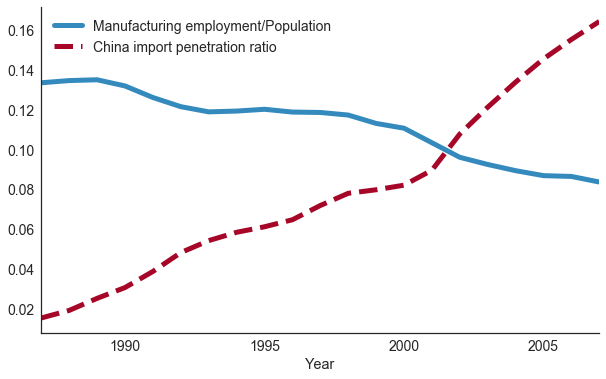

In [58]:
fig, ax = plt.subplots(figsize=(10, 6))

df1 = pd.read_stata("figure1_data.dta")
df1.rename(columns={
    "chnsh": "China import penetration ratio",
    "cpsmanufemppop": "Manufacturing employment/Population",
    "year": "Year"
}, inplace=True)
df1["Year"] = pd.to_datetime(df1["Year"], format="%Y")
df1.set_index("Year", inplace=True)
df1.drop("impr", axis=1, inplace=True)

df1.plot(ax=ax, lw=5, fontsize=14, style=["-", "--"])
ax.legend(prop={"size": 14})
sns.despine(fig)

#### Figure 2

In [59]:
df2 = pd.read_stata("workfile_china_long.dta")

In [60]:
def plot_reg_for_fig2(ax, reg, text_x=20, text_y=25):
    x = "d_tradeotch_pw_lag"
    ax.plot(df2[x], df2[x] * reg.params[x], c=green)
    ax.text(text_x, text_y,
        "coef = {:3.2f}, robust SE = {:3.2f}, t = {:3.2f}".format(
            reg.params[x], 
            np.sqrt(reg.cov_params().iloc[1,1]),
            reg.tvalues[x]
        ),
        fontdict=dict(horizontalalignment='center', size=13),
        bbox={"boxstyle": "square,pad=0.6", "fc": "white"},
    )

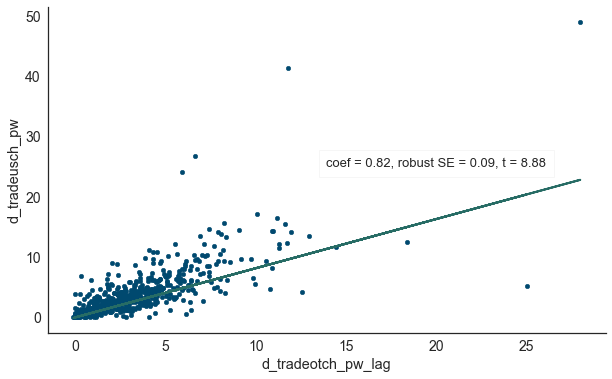

In [61]:
# Panel A. first stage regression
res2A = smf.wls(
        formula="d_tradeusch_pw ~ d_tradeotch_pw_lag + l_shind_manuf_cbp",
        data=df2,
        weights=df2["timepwt48"],

    ).fit(
        cov_type="cluster",
        cov_kwds={"groups": df2["statefip"], 
                  # Default is true for both of these
                 }
    )


fig2, ax2 = plt.subplots(figsize=(10, 6))


# plot data
df2.plot.scatter(x="d_tradeotch_pw_lag", y="d_tradeusch_pw", ax=ax2, c=blue, fontsize=14)
# plot regression
plot_reg_for_fig2(ax2, res2A)
sns.despine(fig2)

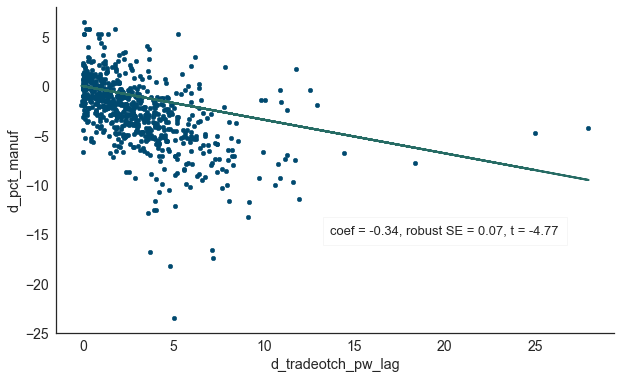

In [62]:
# Panel B. OLS reduced form regression, full sample
res2B = smf.wls(
        formula="d_pct_manuf ~ d_tradeotch_pw_lag + l_shind_manuf_cbp",
        data=df2,
        weights=df2["timepwt48"],

    ).fit(
        cov_type="cluster",
        cov_kwds={"groups": df2["statefip"], 
                  # Default is true for both of these
                 }
    )


fig2B, ax2B = plt.subplots(figsize=(10, 6))
x = "d_tradeotch_pw_lag"

# plot data
df2.plot.scatter(x="d_tradeotch_pw_lag", y="d_pct_manuf", ax=ax2B, c=blue, fontsize=14)
# plot regression
plot_reg_for_fig2(ax2B, res2B, text_y=-15)
sns.despine(fig2B)